In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

24/04/09 12:06:26 WARN Utils: Your hostname, MacBook-Pro-Vadim.local resolves to a loopback address: 127.0.0.1; using 192.168.139.65 instead (on interface en0)
24/04/09 12:06:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/09 12:06:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Загрузите данные при помощи spark.read.csv из приложенного файла

In [50]:
df = spark.read.csv('iris.csv', header=True, inferSchema=True)

In [51]:
df.show(5)

+------------+-----------+------------+-----------+-------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|variety|variety_num|
+------------+-----------+------------+-----------+-------+-----------+
|         5.1|        3.5|         1.4|        0.2| Setosa|          0|
|         4.9|        3.0|         1.4|        0.2| Setosa|          0|
|         4.7|        3.2|         1.3|        0.2| Setosa|          0|
|         4.6|        3.1|         1.5|        0.2| Setosa|          0|
|         5.0|        3.6|         1.4|        0.2| Setosa|          0|
+------------+-----------+------------+-----------+-------+-----------+
only showing top 5 rows



In [52]:
df.dtypes

[('sepal_length', 'double'),
 ('sepal_width', 'double'),
 ('petal_length', 'double'),
 ('petal_width', 'double'),
 ('variety', 'string'),
 ('variety_num', 'int')]

In [53]:
df.describe().show()

+-------+------------------+-------------------+------------------+------------------+---------+------------------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|  variety|       variety_num|
+-------+------------------+-------------------+------------------+------------------+---------+------------------+
|  count|               150|                150|               150|               150|      150|               150|
|   mean| 5.843333333333335|  3.057333333333334|3.7580000000000027| 1.199333333333334|     NULL|               1.0|
| stddev|0.8280661279778637|0.43586628493669793|1.7652982332594662|0.7622376689603467|     NULL|0.8192319205190406|
|    min|               4.3|                2.0|               1.0|               0.1|   Setosa|                 0|
|    max|               7.9|                4.4|               6.9|               2.5|Virginica|                 2|
+-------+------------------+-------------------+------------------+-----

## Воспользуйтесь командами groupBy, max, min и avg, чтобы вывести максимальное минимальное и среднее значние каждого из аттрбутов цветка ('sepal_length','sepal_width','petal_length','petal_width')

In [54]:
df.drop('variety_num').groupby('variety').max().show()

+----------+-----------------+----------------+-----------------+----------------+
|   variety|max(sepal_length)|max(sepal_width)|max(petal_length)|max(petal_width)|
+----------+-----------------+----------------+-----------------+----------------+
| Virginica|              7.9|             3.8|              6.9|             2.5|
|    Setosa|              5.8|             4.4|              1.9|             0.6|
|Versicolor|              7.0|             3.4|              5.1|             1.8|
+----------+-----------------+----------------+-----------------+----------------+



In [55]:
df.drop('variety_num').groupby('variety').min().show()

+----------+-----------------+----------------+-----------------+----------------+
|   variety|min(sepal_length)|min(sepal_width)|min(petal_length)|min(petal_width)|
+----------+-----------------+----------------+-----------------+----------------+
| Virginica|              4.9|             2.2|              4.5|             1.4|
|    Setosa|              4.3|             2.3|              1.0|             0.1|
|Versicolor|              4.9|             2.0|              3.0|             1.0|
+----------+-----------------+----------------+-----------------+----------------+



In [56]:
df.drop('variety_num').groupby('variety').avg().show()

+----------+-----------------+------------------+------------------+------------------+
|   variety|avg(sepal_length)|  avg(sepal_width)| avg(petal_length)|  avg(petal_width)|
+----------+-----------------+------------------+------------------+------------------+
| Virginica|6.587999999999998|2.9739999999999998|             5.552|             2.026|
|    Setosa|5.005999999999999| 3.428000000000001|1.4620000000000002|0.2459999999999999|
|Versicolor|            5.936|2.7700000000000005|              4.26|1.3259999999999998|
+----------+-----------------+------------------+------------------+------------------+



In [13]:
import matplotlib.pyplot as plt

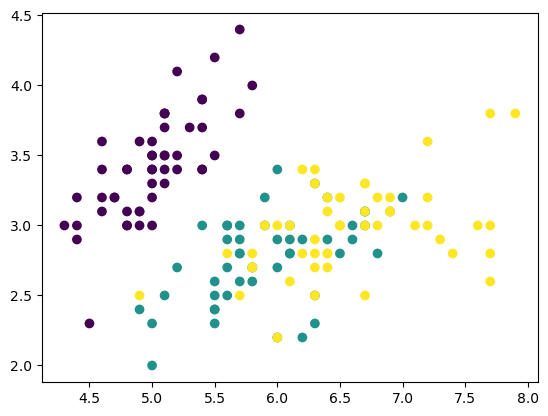

In [14]:
plt.scatter(df[['sepal_length']].collect(), df[['sepal_width']].collect(), c=df[['variety_num']].collect())

## Выведите по аналогии график petal_length и petal_width, так же раскрашенный по типам цветков

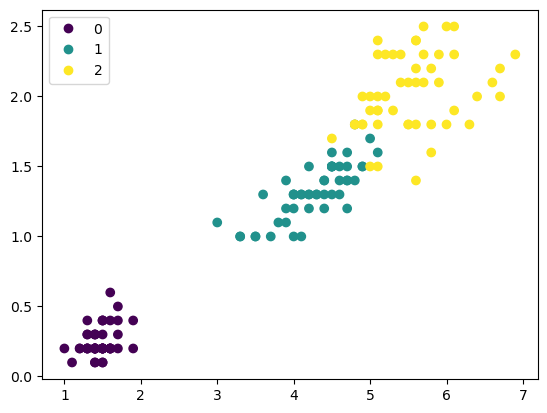

In [29]:
sc = plt.scatter(
    df[['petal_length']].collect(), 
    df[['petal_width']].collect(), 
    c=df[['variety_num']].collect(),
)
plt.legend(*sc.legend_elements())


## Посмотрите внимательно на получившийся график и сформируйте правило вида ЕСЛИ ЗНАЧЕНИЕ ПАРАМЕТРА A < ЗНАЧЕНИЕ, ТО IRIS ОТНОСИТСЯ К КЛАССУ SETOSA - ИНАЧЕ К КАКОМУ-ТО ДРУГОМУ (НАЗОВЕМ, ЕГО НАПРИМЕР UNKNOWN)
## При помощи команд withColumn, when, otherwise создайте в датафрейме новую колонку с таким предсказанием

Если petal_length < 2, то Setosa

In [30]:
from pyspark.sql.functions import when

In [76]:
df_predict = df.withColumn(
    'prediction',
    when(df['petal_length'] < 2, 'Setosa').otherwise('UNKNOWN')
)

## Проверьте качество своего предсказания
Для этого:
1. Подсчитайте количество строк, где Вы предсказали класс Setosa и правильный класс был так же Setosa
2. Подсчитайте количество строк, где Вы предскзали класс Setosa, а правильный класс был какой-то другой (воспользуйтесь оператором "не равно" - !=)

In [77]:
df_predict.where(df_predict['variety'] == df_predict['prediction']).count()

50

In [78]:
df_predict.where(
    (df_predict['variety'] != df_predict['prediction']) &
    (df_predict['prediction'] == 'Setosa')
).count()

0